# Import

In [1]:
# !pip install -U numpy pmdarima

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
!pip install -q --upgrade statsmodels   # ← esegui e aspetta la fine

In [4]:
!pip install -q --upgrade statsmodels


In [5]:
!pip install cdsapi xarray netCDF4 geopandas statsmodels pygrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.2 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from statsmodels.tsa.stattools import adfuller

In [7]:
import requests, time, zipfile, glob, os
import pandas as pd
from datetime import datetime
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import numpy as np
import cdsapi
import calendar
import xarray as xr
import statsmodels.formula.api as smf
import xarray as xr_utils

# Analysis

In [8]:
#milan = pd.read_csv('/content/drive/MyDrive/data_science_lab_on_smart_cities/milan_all.csv')

In [9]:
milan = pd.read_csv('milan_all.csv')

In [10]:
milan.head()

,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,...,FkObservationLog,datetime,EoI,lon,lat,geometry,inside_areaB,date,wind_speed,RH
0,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 00:00:00,2018-01-01 01:00:00,56.857888,ug.m-3,hour,1,1,2019-07-25 14:21:00,...,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 00:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True,2018-01-01,0.821264,85.715370
1,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 01:00:00,2018-01-01 02:00:00,53.771174,ug.m-3,hour,1,1,2019-07-25 14:21:00,...,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 01:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True,2018-01-01,0.151627,82.649190
2,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 02:00:00,2018-01-01 03:00:00,68.027205,ug.m-3,hour,1,1,2019-07-25 14:21:00,...,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 02:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True,2018-01-01,0.184199,82.846430
3,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 03:00:00,2018-01-01 04:00:00,60.123850,ug.m-3,hour,1,1,2019-07-25 14:21:00,...,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 03:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True,2018-01-01,0.518294,82.685745
4,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 04:00:00,2018-01-01 05:00:00,59.702785,ug.m-3,hour,1,1,2019-07-25 14:21:00,...,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 04:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True,2018-01-01,0.994339,89.744790


In [11]:
milan['Validity'].unique()

array([1, 3])

In [12]:
milan.columns.to_list()

['Samplingpoint',
 'Pollutant',
 'Start',
 'End',
 'Value',
 'Unit',
 'AggType',
 'Validity',
 'Verification',
 'ResultTime',
 'DataCapture',
 'FkObservationLog',
 'datetime',
 'EoI',
 'lon',
 'lat',
 'geometry',
 'inside_areaB',
 'date',
 'wind_speed',
 'RH']

In [13]:
milan['datetime'] = pd.to_datetime(milan['datetime'])

In [14]:
gdf = gpd.GeoDataFrame(
    milan,
    geometry=[Point(xy) for xy in zip(milan.lon, milan.lat)],
    crs="EPSG:4326"      # WGS84
)

              outside     inside
date                            
2018-01-01  38.350109  47.629362
2018-01-02  48.618251  59.418835
2018-01-03  69.143164  79.579354
2018-01-04  62.064168  72.202516
2018-01-05  57.928868  65.512073


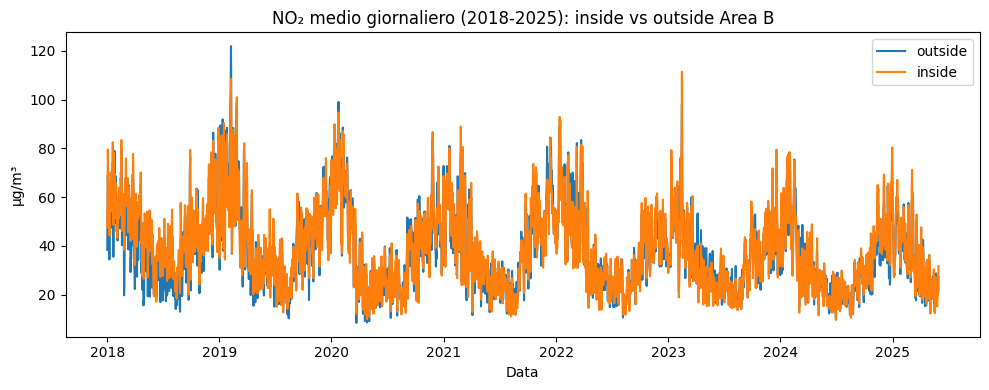

In [15]:
# 2️⃣ Estrai la data dal timestamp di inizio
milan["date"] = pd.to_datetime(milan["Start"]).dt.date

# 3️⃣ Calcola la media NO₂ giornaliera per inside/outside
daily = (
    milan
    .groupby(["date","inside_areaB"])["Value"]
    .mean()
    .reset_index()
)

# 4️⃣ Pivot per confronto diretto
pivot = daily.pivot(index="date", columns="inside_areaB", values="Value")
pivot.columns = ["outside","inside"]

# 5️⃣ Anteprima tabellare
print(pivot.head())

# 6️⃣ Grafico comparativo
fig, ax = plt.subplots(figsize=(10,4))
pivot.plot(ax=ax)
ax.set_title("NO₂ medio giornaliero (2018-2025): inside vs outside Area B")
ax.set_xlabel("Data")
ax.set_ylabel("µg/m³")
plt.tight_layout()
plt.show()

              outside     inside
month                           
2018-01-01  57.100334  61.966248
2018-02-01  50.984396  56.313600
2018-03-01  50.450493  57.561508
2018-04-01  39.354378  49.986492
2018-05-01  32.204307  42.406462


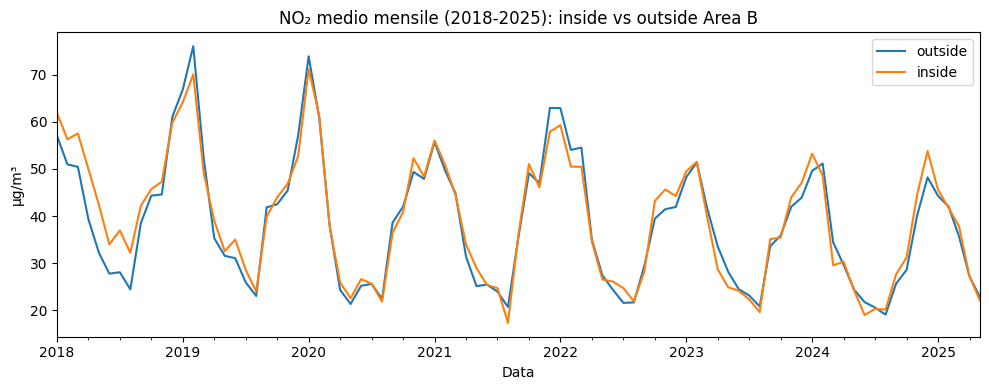

In [16]:
# 2️⃣ Estrai anno e mese dal timestamp di inizio
milan["month"] = pd.to_datetime(milan["Start"]).dt.to_period("M").dt.to_timestamp()

# 3️⃣ Calcola la media NO₂ mensile per inside/outside
monthly = (
    milan
    .groupby(["month", "inside_areaB"])["Value"]
    .mean()
    .reset_index()
)

# 4️⃣ Pivot per confronto diretto
pivot = monthly.pivot(index="month", columns="inside_areaB", values="Value")
pivot.columns = ["outside", "inside"]

# 5️⃣ Anteprima tabellare
print(pivot.head())

# 6️⃣ Grafico comparativo
fig, ax = plt.subplots(figsize=(10, 4))
pivot.plot(ax=ax)
ax.set_title("NO₂ medio mensile (2018-2025): inside vs outside Area B")
ax.set_xlabel("Data")
ax.set_ylabel("µg/m³")
plt.tight_layout()
plt.show()

# Time Series Analysis

##Preparazione


In [17]:
#PREPARAZIONE

import pandas as pd
import matplotlib.pyplot as plt

# 👉 1.1  Assicuriamoci che la colonna 'date' esista e sia un DateTimeIndex
pivot.index = pd.to_datetime(pivot.index)          #  pivot è la tabella che hai creato al §12
pivot = pivot.sort_index()

# 👉 1.2  Passiamo da media giornaliera a media mensile
monthly = pivot.resample('MS').mean()              # 'MS' = Month Start


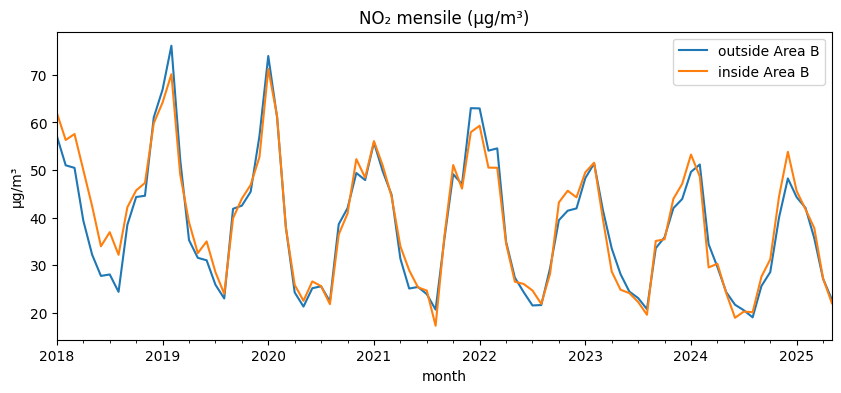

In [18]:
#ANALISI DEL GRAFICO

fig, ax = plt.subplots(figsize=(10,4))
monthly['outside'].plot(ax=ax, label='outside Area B')
monthly['inside'].plot(ax=ax, label='inside Area B')
ax.set(title='NO₂ mensile (µg/m³)', ylabel='µg/m³')
ax.legend(); plt.show()


## Training e test set

In [19]:
monthly

,outside,inside
month,,
2018-01-01,57.100334,61.966248
2018-02-01,50.984396,56.313600
2018-03-01,50.450493,57.561508
2018-04-01,39.354378,49.986492
2018-05-01,32.204307,42.406462
...,...,...
2025-01-01,44.274214,45.561508
2025-02-01,42.046544,41.747501
2025-03-01,35.653868,37.789954


In [23]:
# Suddivisione train/test
train = monthly.loc[:'2024-05-31']
test  = monthly.loc['2024-06-01':'2025-12-31']

##Verifica stazionarieta' e stagionalita'

In [27]:
monthly = train.copy()

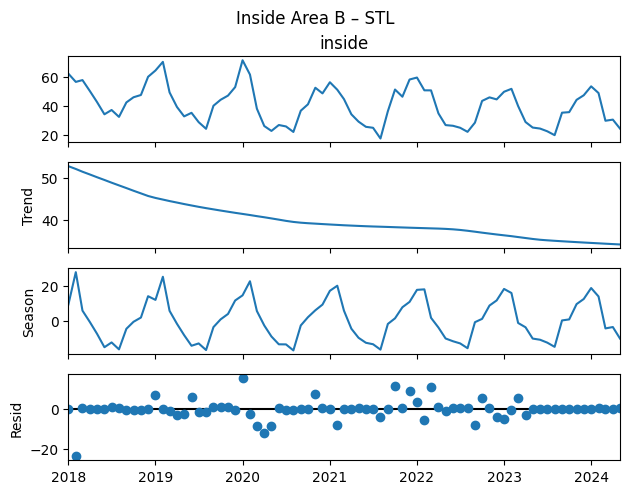

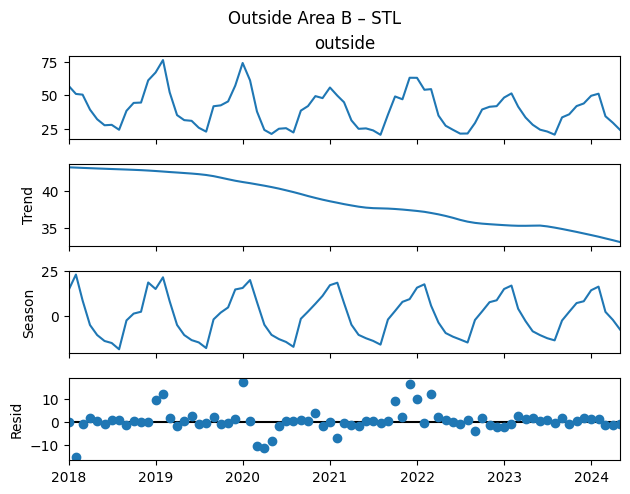

In [28]:
#DECOMPOSIZIONE TREND STAGIONALITA' RESIDUI

from statsmodels.tsa.seasonal import STL

inside_stl  = STL(monthly['inside'],  period=12, robust=True).fit()
outside_stl = STL(monthly['outside'], period=12, robust=True).fit()

inside_stl.plot();  plt.suptitle('Inside Area B – STL', y=1.02);  plt.show()
outside_stl.plot(); plt.suptitle('Outside Area B – STL',y=1.02); plt.show()


| Componente       | Inside Area B                                                                                                           | Outside Area B                                                          | Lettura                                                                                                                                                                                 |
| ---------------- | ----------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Trend**        | Scende da ≈ 55 µg/m³ (inizio 2018) a ≈ 32 µg/m³ (mag-25) con pendenza marcata fra 2018-20 e lieve appiattimento 2022-23 | Da ≈ 46 µg/m³ a ≈ 31 µg/m³, ma con pendenza più dolce                   | Riduzione più rapida **dentro** l’Area B → possibili effetti di Area B/Area C, rinnovo flotte, LTZ, ecc.                                                                                |
| **Stagionalità** | Ampiezza \~ ±18-20 µg/m³ (picco invernale, minimo estivo) abbastanza costante                                           | Ampiezza leggermente minore (\~ ±15-18 µg/m³) ma molto simile come fase | Il pattern è coerente: NO₂ invernale elevato (riscaldamento + inversioni), minimo estivo (foto-chimica + ferie). Amplitude costante ⇒ assunzione di stagionalità “additiva” regge bene. |
| **Residui**      | Distribuiti intorno a 0, qualche outlier ±10-15 µg/m³ (2020-21). Varianza pressoché costante                            | Più outlier positivi (2021-22), per il resto simile                     | Residui **visivamente** ≈ white-noise, nessuna varianza crescente: buona premessa per ARIMA/SARIMA, ma occorrono test formali.                                                          |


In [29]:
#TEST STAZIONARIETA'

from statsmodels.tsa.stattools import adfuller

def adf(x):
    res = adfuller(x.dropna())
    return pd.Series(res[:4], index=['ADF','p-value','n_obs','lags'])

print('\nInside:\n',  adf(monthly['inside']))
print('\nOutside:\n', adf(monthly['outside']))



Inside:
 ADF        -1.244005
p-value     0.654385
n_obs      11.000000
lags       65.000000
dtype: float64

Outside:
 ADF        -0.825793
p-value     0.811428
n_obs      10.000000
lags       66.000000
dtype: float64


Cosa guardare:
* p-value > 0.05 ⇒ non stazionaria → differenziare (d=1);

* se la stagionalità è forte, potresti fare anche una differenza stagionale (D=1, periodo = 12).

Inside ha p-value di 0.63 > 0.05 -> Non Stazionaria

Outside ha p-value prossimo di 0.92 > 0.05 -> Non Stazionaria

###TRASFORMAZIONE LOGARITMICA

In [30]:
log_data = monthly.copy()
log_data = np.log(log_data)
log_data.columns = ['inside', 'outside']
log_data

,inside,outside
month,,
2018-01-01,4.044810,4.126590
2018-02-01,3.931520,4.030936
2018-03-01,3.920993,4.052854
2018-04-01,3.672607,3.911753
2018-05-01,3.472100,3.747301
...,...,...
2024-01-01,3.904118,3.974902
2024-02-01,3.934911,3.884246
2024-03-01,3.538192,3.384941


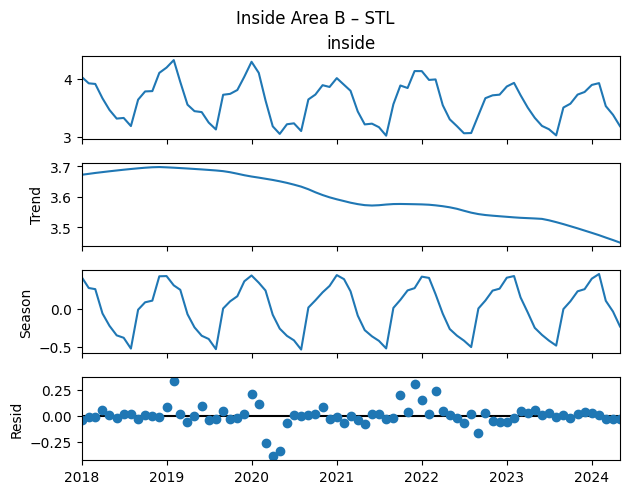

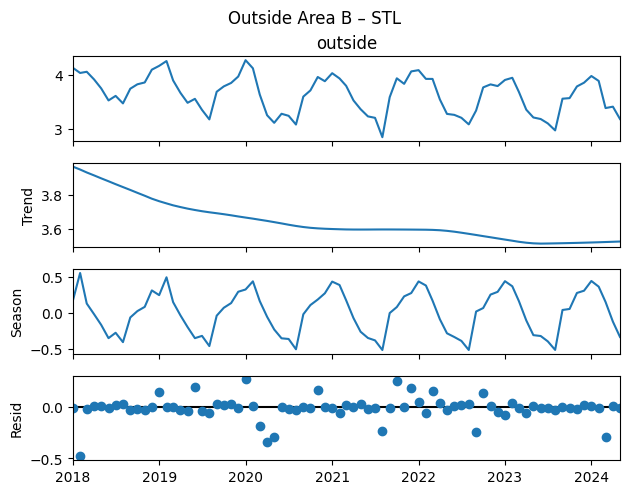

In [31]:
#DECOMPOSIZIONE TREND STAGIONALITA' RESIDUI

from statsmodels.tsa.seasonal import STL

inside_stl_l  = STL(log_data['inside'],  period=12, robust=True).fit()
outside_stl_l = STL(log_data['outside'], period=12, robust=True).fit()

inside_stl_l.plot();  plt.suptitle('Inside Area B – STL', y=1.02);  plt.show()
outside_stl_l.plot(); plt.suptitle('Outside Area B – STL',y=1.02); plt.show()

###DESTAGIONALIZZAZIONE 1

In [32]:
#CREO DATASET DESTAGIONALIZZATO
deseason_data = log_data.copy()

inside_stl  = STL(deseason_data['inside'],  period=12, robust=True).fit()
outside_stl = STL(deseason_data['outside'], period=12, robust=True).fit()

deseason_data['outside'] = deseason_data['outside'] - outside_stl.seasonal
deseason_data.name = 'outside_deseasonalized'

deseason_data['inside'] = deseason_data['inside'] - inside_stl.seasonal
deseason_data.name = 'inside_deseasonalized'
deseason_data

,inside,outside
month,,
2018-01-01,3.633504,3.958269
2018-02-01,3.664833,3.471298
2018-03-01,3.669076,3.920341
2018-04-01,3.735940,3.928777
2018-05-01,3.695447,3.912984
...,...,...
2024-01-01,3.516117,3.526941
2024-02-01,3.486623,3.515882
2024-03-01,3.437318,3.230594


In [33]:
#VERIFICA STAZIONARIETA' DOPO DESTAGIONALIZZAZIONE

def adf(x):
    res = adfuller(x.dropna())
    return pd.Series(res[:4], index=['ADF','p-value','n_obs','lags'])

print('\nInside:\n',  adf(deseason_data['inside']))
print('\nOutside:\n', adf(deseason_data['outside']))


Inside:
 ADF        -4.041232
p-value     0.001209
n_obs       0.000000
lags       76.000000
dtype: float64

Outside:
 ADF        -5.058450
p-value     0.000017
n_obs       0.000000
lags       76.000000
dtype: float64


i P-value diminuiscono.

Inside si abbassa molto < 0.05 -> Stazionaria

Outside rimane altro > 0.05 -> Non stazionaria

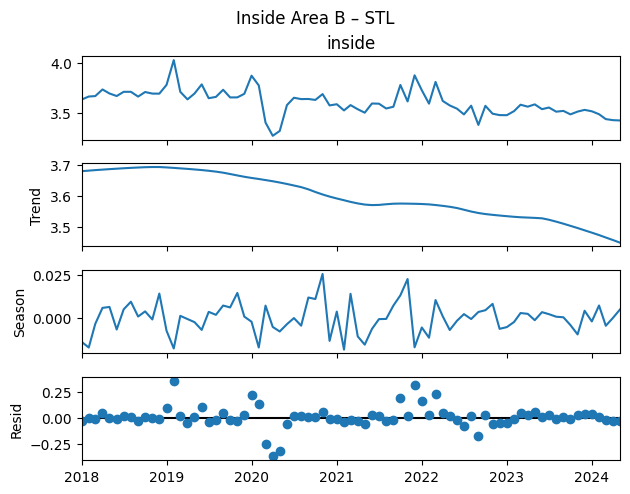

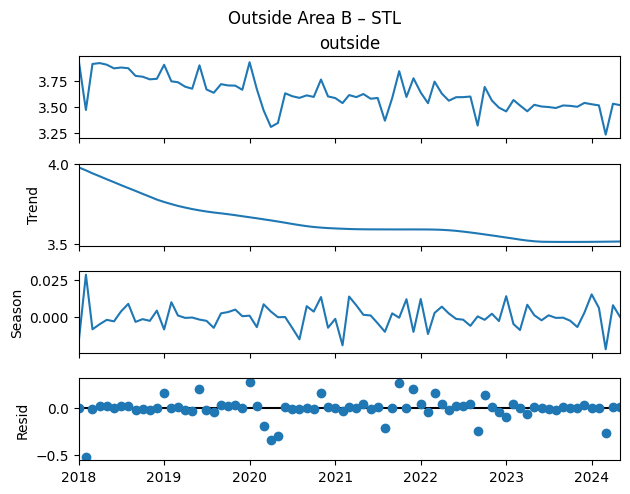

In [34]:
#DECOMPOSIZIONE TREND STAGIONALITA' RESIDUI CON DATASET LOG E DESTAGIONALIZZATO

inside_stl_de  = STL(deseason_data['inside'],  period=12, robust=True).fit()
outside_stl_de = STL(deseason_data['outside'], period=12, robust=True).fit()

inside_stl_de.plot();  plt.suptitle('Inside Area B – STL', y=1.02);  plt.show()
outside_stl_de.plot(); plt.suptitle('Outside Area B – STL',y=1.02); plt.show()

###DIFFERENZIAZIONE

In [43]:
#APPLICO DIFFERENZIAZIONE

inside_lvl  = deseason_data['inside']
outside_lvl = deseason_data['outside']

# inside_d1 = np.log(inside_lvl)
inside_d1 = inside_lvl.diff(1).dropna()

# outside_log = np.log(outside_lvl)
outside_d1 = outside_lvl.diff(2).dropna()

print('ADF inside lvl  p=', adfuller(inside_lvl.dropna())[1])   # P-value senza differenziazione 0.43
print('ADF inside diff p=', adfuller(inside_d1)[1])             # P-value con differenziazione 1 < 0.05
print('ADF outside lvl p=', adfuller(outside_lvl.dropna())[1])  # ~5.6e-5
print('ADF outside diff p=', adfuller(outside_d1)[1])           # P-value con trasf logaritmica

ADF inside lvl  p= 0.001209348726012705
ADF inside diff p= 5.2701895982457985e-06
ADF outside lvl p= 1.6982196990954677e-05
ADF outside diff p= 6.460644385489804e-05


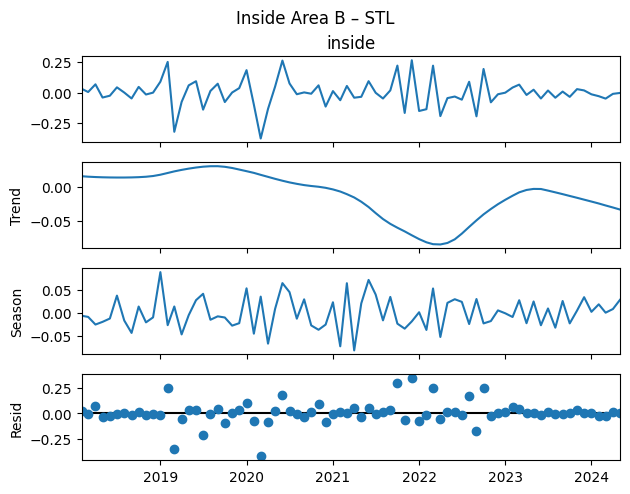

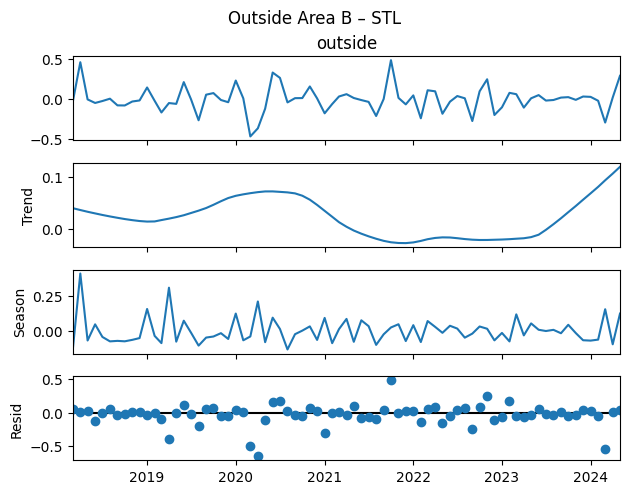

In [44]:
#DECOMPOSIZIONE TREND STAGIONALITA' RESIDUI CON DATASET DESTAGIONALIZZATO E DIFFERENZIATO

inside_stl_d1  = STL(inside_d1,  period=12, robust=True).fit()
outside_stl_d1 = STL(outside_d1, period=12, robust=True).fit()

inside_stl_d1.plot();  plt.suptitle('Inside Area B – STL', y=1.02);  plt.show()
outside_stl_d1.plot(); plt.suptitle('Outside Area B – STL',y=1.02); plt.show()

##MODELLI

In [45]:
inside_d1
outside_d1

,outside
month,
2018-03-01,-0.037927
2018-04-01,0.457479
2018-05-01,-0.007358
2018-06-01,-0.051682
2018-07-01,-0.027443
...,...
2024-01-01,0.024479
2024-02-01,-0.024230
2024-03-01,-0.296348


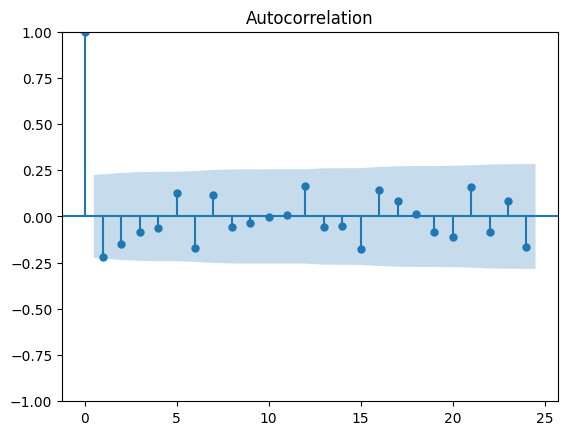

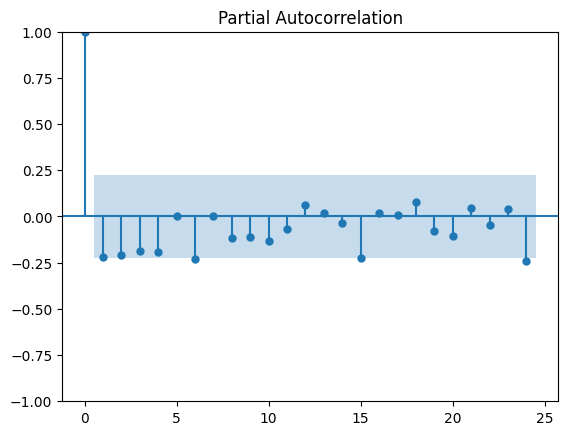

In [46]:
#GRAFICI INSIDE

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(inside_d1.dropna(), lags=24); plt.show()
plot_pacf(inside_d1.dropna(), lags=24); plt.show()

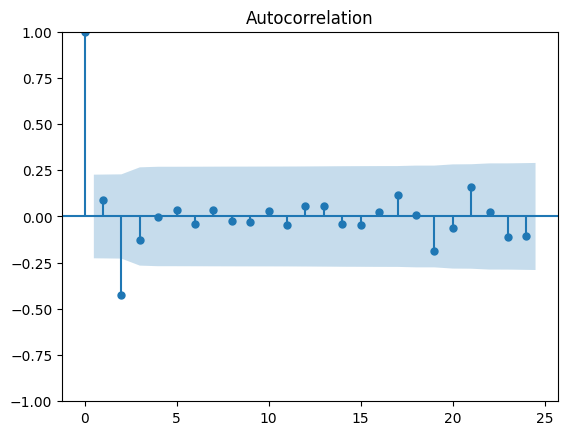

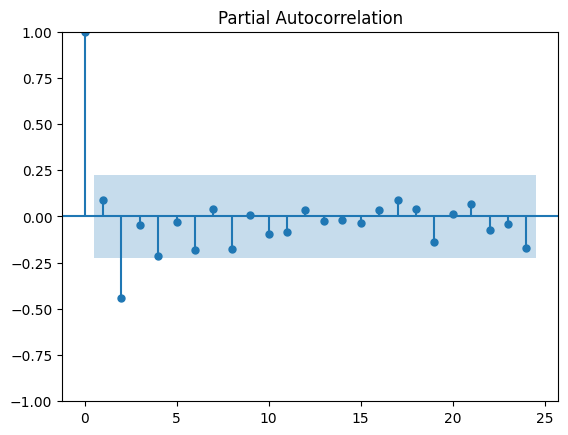

In [47]:
#GRAFICI OUTSIDE

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(outside_d1.dropna(), lags=24); plt.show()
plot_pacf(outside_d1.dropna(), lags=24); plt.show()

COSTRUZIONE MODELLO ARIMA

In [51]:
from statsmodels.tsa.arima.model import ARIMA

# INSIDE ARIMA(p,d,q), con d=0 perché hai già differenziato
model_in = ARIMA(inside_lvl, order=(1, 1, 1))  # scegli p e q in base ad ACF/PACF, uso serie differenziata
model_fit_in = model_in.fit()
print(model_fit_in.summary())

# OUTSIDE ARIMA(p,d,q), con d=0 perché hai già differenziato
model_out = ARIMA(outside_lvl, order=(1, 2, 1))  # scegli p e q in base ad ACF/PACF, uso serie differenziata
model_fit_out = model_out.fit()
print(model_fit_out.summary())

                               SARIMAX Results                                
Dep. Variable:                 inside   No. Observations:                   77
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  67.244
Date:                Thu, 03 Jul 2025   AIC                           -128.489
Time:                        09:44:09   BIC                           -121.496
Sample:                    01-01-2018   HQIC                          -125.694
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4834      0.145      3.329      0.001       0.199       0.768
ma.L1         -0.9116      0.121     -7.511      0.000      -1.149      -0.674
sigma2         0.0099      0.001      8.195      0.0

# PREVISIONI

PREVISIONI SUL TEST

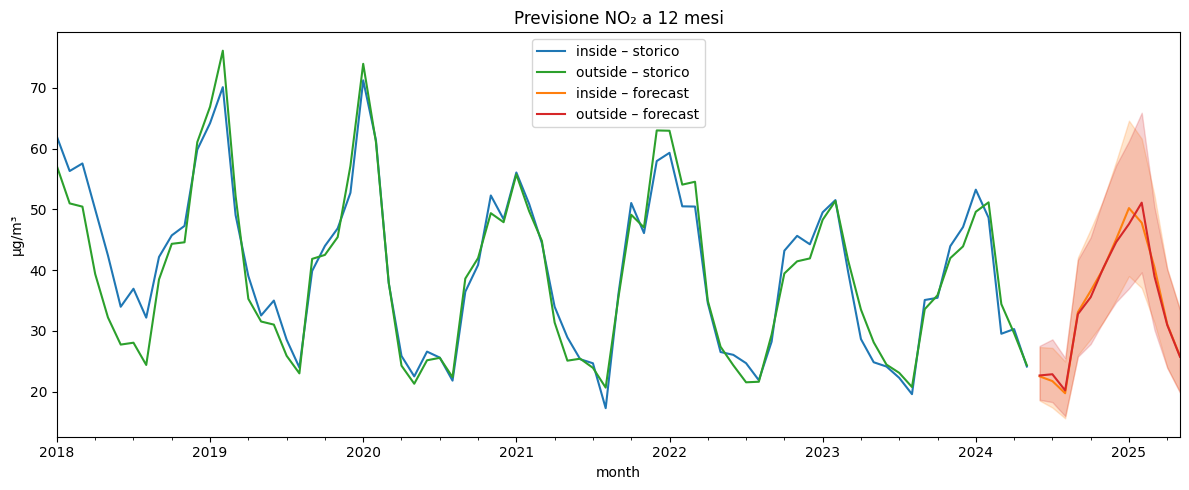

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

# --- PREVISIONE A 12 MESI ---
h = 12
pred_in = model_fit_in.get_forecast(steps=h)
pred_in_mean = pred_in.predicted_mean
ci_in = pred_in.conf_int()

pred_out = model_fit_in.get_forecast(steps=h)
pred_out_mean = pred_out.predicted_mean
ci_out = pred_out.conf_int()


# Costruzione indice temporale per le previsioni
last_date_in = inside_d1.index[-1]
future_dates = pd.date_range(last_date_in + pd.DateOffset(months=1), periods=h, freq='MS')
pred_in_mean.index = future_dates
ci_in.index = future_dates


# --- RICOSTRUZIONE: AGGIUNTA STAGIONALITÀ ---
# Estrai la stagionalità mensile media (1 valore per ciascun mese)
seasonal_values_in = inside_stl.seasonal.groupby(inside_stl.seasonal.index.month).mean()
future_seasonality_in = [seasonal_values_in[month] for month in future_dates.month]
future_seasonality_in = pd.Series(future_seasonality_in, index=future_dates)

seasonal_values_out = outside_stl.seasonal.groupby(outside_stl.seasonal.index.month).mean()
future_seasonality_out = [seasonal_values_out[month] for month in future_dates.month]
future_seasonality_out = pd.Series(future_seasonality_out, index=future_dates)


# Aggiungi la stagionalità alla previsione
forecast_with_seasonality_in = pred_in_mean + future_seasonality_in

forecast_with_seasonality_out = pred_out_mean + future_seasonality_out


# --- RICOSTRUZIONE: INVERSIONE DEL LOGARITMO ---
final_forecast_in = np.exp(forecast_with_seasonality_in)

final_forecast_out = np.exp(forecast_with_seasonality_out)


# --- GRAFICO ---
# ax = monthly['inside'].plot(label='inside – storico', figsize=(10, 4))
# final_forecast_in.plot(ax=ax, label='inside – forecast')
# ax.fill_between(final_forecast.index,
#                 np.exp(ci.iloc[:, 0] + future_seasonality),
#                 np.exp(ci.iloc[:, 1] + future_seasonality),
#                 alpha=0.2)

# ax.set(title='Previsione NO₂ a 12 mesi', ylabel='µg/m³')
# ax.legend()
# plt.show()

import matplotlib.pyplot as plt

# Ricostruzione intervalli di confidenza sulla scala originale (log^-1 = exp)
ci_in_lower = np.exp(ci_in.iloc[:, 0] + future_seasonality_in)
ci_in_upper = np.exp(ci_in.iloc[:, 1] + future_seasonality_in)

ci_out_lower = np.exp(ci_out.iloc[:, 0] + future_seasonality_out)
ci_out_upper = np.exp(ci_out.iloc[:, 1] + future_seasonality_out)

# Grafico
fig, ax = plt.subplots(figsize=(12, 5))

# Serie storiche
monthly['inside'].plot(ax=ax, label='inside – storico', color='C0')
monthly['outside'].plot(ax=ax, label='outside – storico', color='C2')

# Previsioni
final_forecast_in.plot(ax=ax, label='inside – forecast', color='C1')
final_forecast_out.plot(ax=ax, label='outside – forecast', color='C3')

# Intervalli di confidenza
ax.fill_between(final_forecast_in.index, ci_in_lower, ci_in_upper, alpha=0.2, color='C1')
ax.fill_between(final_forecast_out.index, ci_out_lower, ci_out_upper, alpha=0.2, color='C3')

# Etichette e legenda
ax.set(title='Previsione NO₂ a 12 mesi', ylabel='µg/m³')
ax.legend()
plt.tight_layout()
plt.show()



--- INSIDE ---
MAE      : 4.19
RMSE     : 4.68
MAPE     : 12.86%
Accuracy : 87.14%

--- OUTSIDE ---
MAE      : 3.76
RMSE     : 4.55
MAPE     : 12.36%
Accuracy : 87.64%


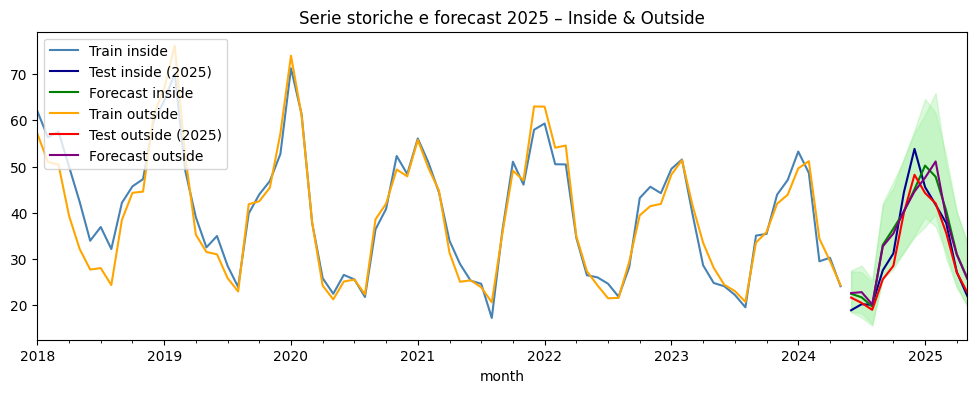

In [77]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
import numpy as np
import matplotlib.pyplot as plt

# --------- METRICHE “inside” ---------
mae_in  = mean_absolute_error(test['inside'], final_forecast_in)
rmse_in = np.sqrt(mean_squared_error(test['inside'], final_forecast_in))
mape_in = mean_absolute_percentage_error(test['inside'], final_forecast_in) * 100
acc_in  = 100 - mape_in

# --------- METRICHE “outside” ---------
mae_out  = mean_absolute_error(test['outside'], final_forecast_out)
rmse_out = np.sqrt(mean_squared_error(test['outside'], final_forecast_out))
mape_out = mean_absolute_percentage_error(test['outside'], final_forecast_out) * 100
acc_out  = 100 - mape_out

# --------- STAMPA RISULTATI ---------
print("--- INSIDE ---")
print(f"MAE      : {mae_in:.2f}")
print(f"RMSE     : {rmse_in:.2f}")
print(f"MAPE     : {mape_in:.2f}%")
print(f"Accuracy : {acc_in:.2f}%\n")

print("--- OUTSIDE ---")
print(f"MAE      : {mae_out:.2f}")
print(f"RMSE     : {rmse_out:.2f}")
print(f"MAPE     : {mape_out:.2f}%")
print(f"Accuracy : {acc_out:.2f}%")

# --------- GRAFICO CONFRONTO ---------
fig, ax = plt.subplots(figsize=(12, 4))

# Inside
train['inside'].plot(ax=ax, label='Train inside', color='steelblue')
test['inside'].plot(ax=ax, label='Test inside (2025)', color='darkblue')
final_forecast_in.plot(ax=ax, label='Forecast inside', color='green')
ax.fill_between(
    ci_in.index, ci_in_lower, ci_in_upper,
    color='lightgreen', alpha=0.3
)

# Outside
train['outside'].plot(ax=ax, label='Train outside', color='orange')
test['outside'].plot(ax=ax, label='Test outside (2025)', color='red')
final_forecast_out.plot(ax=ax, label='Forecast outside', color='purple')
ax.fill_between(
    ci_in.index, ci_out_lower, ci_out_upper,
    color='lightgreen', alpha=0.3)

ax.set_title("Serie storiche e forecast 2025 – Inside & Outside")
ax.legend()
plt.show()


RMSE MAE ACCURACY DI INSIDE

### INSIDE ###
MAE      : 4.19
RMSE     : 4.68
MAPE     : 12.86%
Accuracy : 87.14%


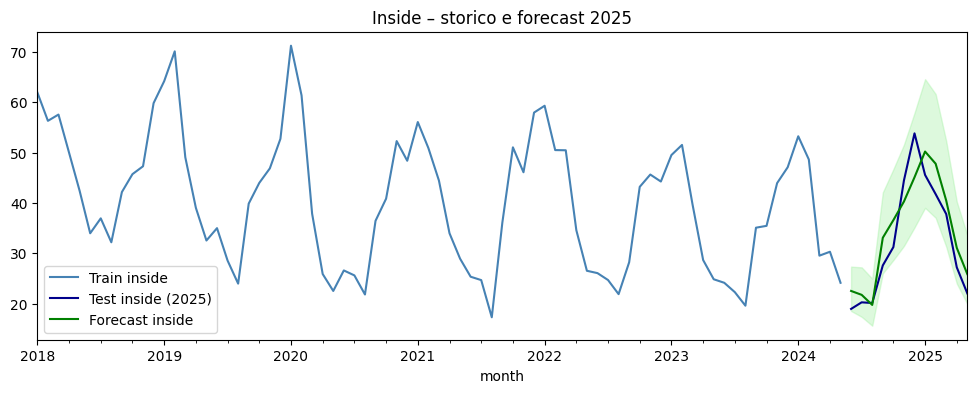

In [78]:
# --- INSIDE: metriche e grafico -----------------------------------
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error)
import numpy as np
import matplotlib.pyplot as plt

# --------- METRICHE "inside" ---------
mae_in  = mean_absolute_error(test['inside'], final_forecast_in)
rmse_in = np.sqrt(mean_squared_error(test['inside'], final_forecast_in))
mape_in = mean_absolute_percentage_error(test['inside'], final_forecast_in) * 100
acc_in  = 100 - mape_in

print("### INSIDE ###")
print(f"MAE      : {mae_in:.2f}")
print(f"RMSE     : {rmse_in:.2f}")
print(f"MAPE     : {mape_in:.2f}%")
print(f"Accuracy : {acc_in:.2f}%")

# --------- GRAFICO "inside" ---------
# (ci_in si presume DataFrame con lower/upper, in alternativa adatta i nomi)

fig, ax = plt.subplots(figsize=(12, 4))
train['inside'].plot(ax=ax, label='Train inside', color='steelblue')
test['inside'].plot(ax=ax, label='Test inside (2025)', color='darkblue')
final_forecast_in.plot(ax=ax, label='Forecast inside', color='green')
ax.fill_between(ci_in.index, ci_in_lower, ci_in_upper,
                color='lightgreen', alpha=0.3)
ax.set_title("Inside – storico e forecast 2025")
ax.legend()
plt.show()


RMSE MAE ACCURACY DI OUTSIDE

### OUTSIDE ###
MAE      : 3.76
RMSE     : 4.55
MAPE     : 12.36%
Accuracy : 87.64%


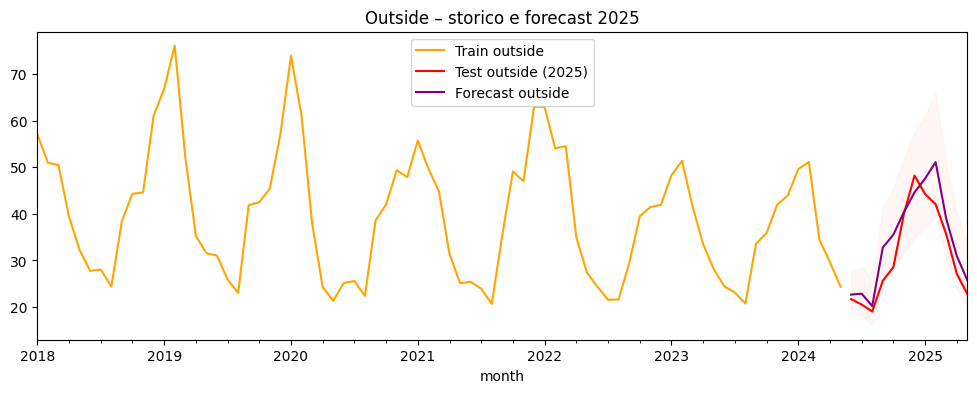

In [79]:
# --- OUTSIDE: metriche e grafico ----------------------------------
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error)
import numpy as np
import matplotlib.pyplot as plt

# --------- METRICHE "outside" ---------
mae_out  = mean_absolute_error(test['outside'], final_forecast_out)
rmse_out = np.sqrt(mean_squared_error(test['outside'], final_forecast_out))
mape_out = mean_absolute_percentage_error(test['outside'], final_forecast_out) * 100
acc_out  = 100 - mape_out

print("### OUTSIDE ###")
print(f"MAE      : {mae_out:.2f}")
print(f"RMSE     : {rmse_out:.2f}")
print(f"MAPE     : {mape_out:.2f}%")
print(f"Accuracy : {acc_out:.2f}%")

# --------- GRAFICO "outside" ---------
# (ci_out si presume DataFrame con lower/upper)

fig, ax = plt.subplots(figsize=(12, 4))
train['outside'].plot(ax=ax, label='Train outside', color='orange')
test['outside'].plot(ax=ax, label='Test outside (2025)', color='red')
final_forecast_out.plot(ax=ax, label='Forecast outside', color='purple')
ax.fill_between(ci_out.index, ci_out_lower, ci_out_upper,
                color='mistyrose', alpha=0.3)
ax.set_title("Outside – storico e forecast 2025")
ax.legend()
plt.show()


PREVISIONI 2026

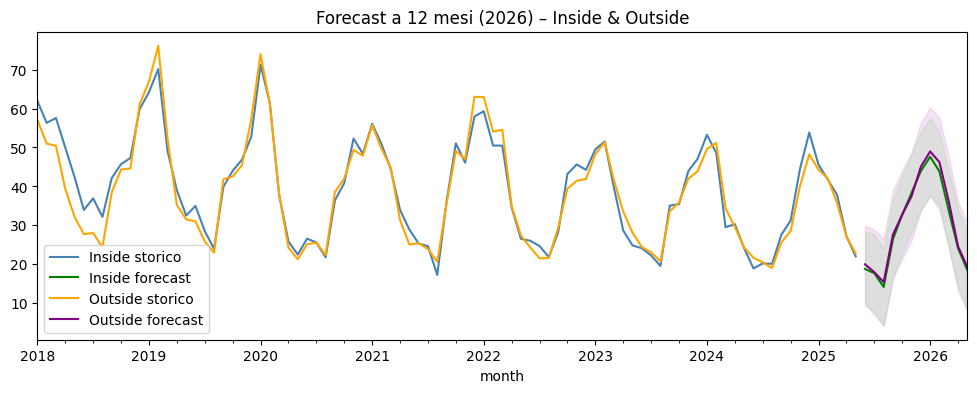

In [80]:
# ------------ SETUP -------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd

h = 12          # orizzonte forecast in mesi

# ------------ UNISCI TRAIN + TEST ----------------------------------
# (NB: train e test devono avere stesso indice DatetimeIndex)
full_inside  = pd.concat([train['inside'],  test['inside']])
full_outside = pd.concat([train['outside'], test['outside']])

# ------------ MODELLI E FORECAST -----------------------------------
def sarima_forecast(series, order=(1,1,1), seasonal_order=(1,1,1,12), steps=12):
    model = SARIMAX(series,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False)
    res = model.fit(disp=False)
    fcst = res.get_forecast(steps=steps)
    return fcst.predicted_mean, fcst.conf_int()

# -- Inside
forecast_in, ci_in = sarima_forecast(full_inside, steps=h)
ci_in_lower = ci_in.iloc[:, 0]
ci_in_upper = ci_in.iloc[:, 1]

# -- Outside
forecast_out, ci_out = sarima_forecast(full_outside, steps=h)
ci_out_lower = ci_out.iloc[:, 0]
ci_out_upper = ci_out.iloc[:, 1]

# ------------ GRAFICO RISULTATI ------------------------------------
fig, ax = plt.subplots(figsize=(12, 4))

full_inside.plot(ax=ax, label='Inside storico', color='steelblue')
forecast_in.plot(ax=ax, label='Inside forecast', color='green')
ax.fill_between(ci_in.index, ci_in_lower, ci_in_upper,
                color='lightgreen', alpha=0.3)

full_outside.plot(ax=ax, label='Outside storico', color='orange')
forecast_out.plot(ax=ax, label='Outside forecast', color='purple')
ax.fill_between(ci_out.index, ci_out_lower, ci_out_upper,
                color='plum', alpha=0.3)

ax.set_title("Forecast a 12 mesi (2026) – Inside & Outside")
ax.legend()
plt.show()
